In [4]:
import datetime
import math
import os
from os import path, replace
from pathlib import Path
import sys
from pprint import pprint

import random

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

from PIL import Image
import numpy as np

import matplotlib.pyplot as plt

In [5]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.dirname(os.path.abspath(".")))

from util.helpers import reseed
from dataset import EndoVisDataset, inv_im_trans, im_mean

In [3]:
MAIN_FOLDER = Path.home() / "plaksha/SurgicalAI/data/endovis/endo17/data"
TRAIN_VIDEOS_PATH = MAIN_FOLDER / "frames/train"
TRAIN_MASKS_PATH = MAIN_FOLDER / "masks/train/binary_masks"
SAVE_DIR = Path("./artifacts/saved_models")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Set seed to ensure the same initialization
reseed(42)

transforms_dict = {}
# These set of transform is the same for im/gt pairs, but different among the 3 sampled frames
transforms_dict["single_image"] = transforms.Compose([
    transforms.ColorJitter(0.01, 0.01, 0.01, 0),
])

transforms_dict["pair_image_gt"] = [
    transforms.Compose([
        transforms.RandomAffine(15, shear=10, interpolation=InterpolationMode.BILINEAR, fill=im_mean) # for images
    ]),
    transforms.Compose([
        transforms.RandomAffine(15, shear=10, interpolation=InterpolationMode.NEAREST, fill=0) # for masks
    ])
]

# These transform are the same for all pairs in the sampled sequence
transforms_dict["seq_image"] = transforms.Compose([
    transforms.ColorJitter(0.1, 0.03, 0.03, 0),
    transforms.RandomGrayscale(0.05),
])


transforms_dict["seq_image_gt"] = [
    transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((384, 384), scale=(0.36,1.00), interpolation=InterpolationMode.BILINEAR) # for images
    ]),
    transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop((384, 384), scale=(0.36,1.00), interpolation=InterpolationMode.NEAREST) # for masks
    ])
]

train_dataset = EndoVisDataset(
    TRAIN_VIDEOS_PATH,
    TRAIN_MASKS_PATH,
    num_iterations=100,#config["iterations"],
    batch_size=2,#config["batch_size"],
    max_jump=20,
    num_frames=8,
    max_num_obj=1,
    transform=transforms_dict,
    subset=[1,2,3,4]
)

4 out of 8 videos accepted in /Users/syedal/plaksha/SurgicalAI/data/endovis/endo17/data/frames/train.


In [4]:
data = train_dataset[1]

In [5]:
data.keys()

dict_keys(['rgb', 'first_frame_gt', 'cls_gt', 'selector', 'info'])

In [6]:
def plotDatasetSample(dataset, rows):
    first_seq = dataset[random.randint(0, len(dataset))]
    print('rgb', first_seq['rgb'].shape)
    print('first_frame_gt', first_seq['first_frame_gt'].shape)
    print('cls_gt', first_seq['cls_gt'].shape)
    print('selector', first_seq['selector'])
    print('info', first_seq['info'])

    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(10, 15))
    
    for i in range(rows):
        # Plot RGB image
        rgb_image = inv_im_trans(first_seq['rgb'][i]).permute(1,2,0).numpy()
        axes[i, 0].imshow(rgb_image)
        axes[i, 0].axis('off')
        
        # Plot binary mask
        mask = first_seq['cls_gt'][i][0]
        axes[i, 1].imshow(mask, cmap='gray')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()    

rgb torch.Size([8, 3, 384, 384])
first_frame_gt (1, 1, 384, 384)
cls_gt (8, 1, 384, 384)
selector tensor([1.])
info {'name': 'instrument_dataset_04', 'frames': ['31', '34', '38', '44', '51', '58', '65', '80'], 'num_objects': 1}


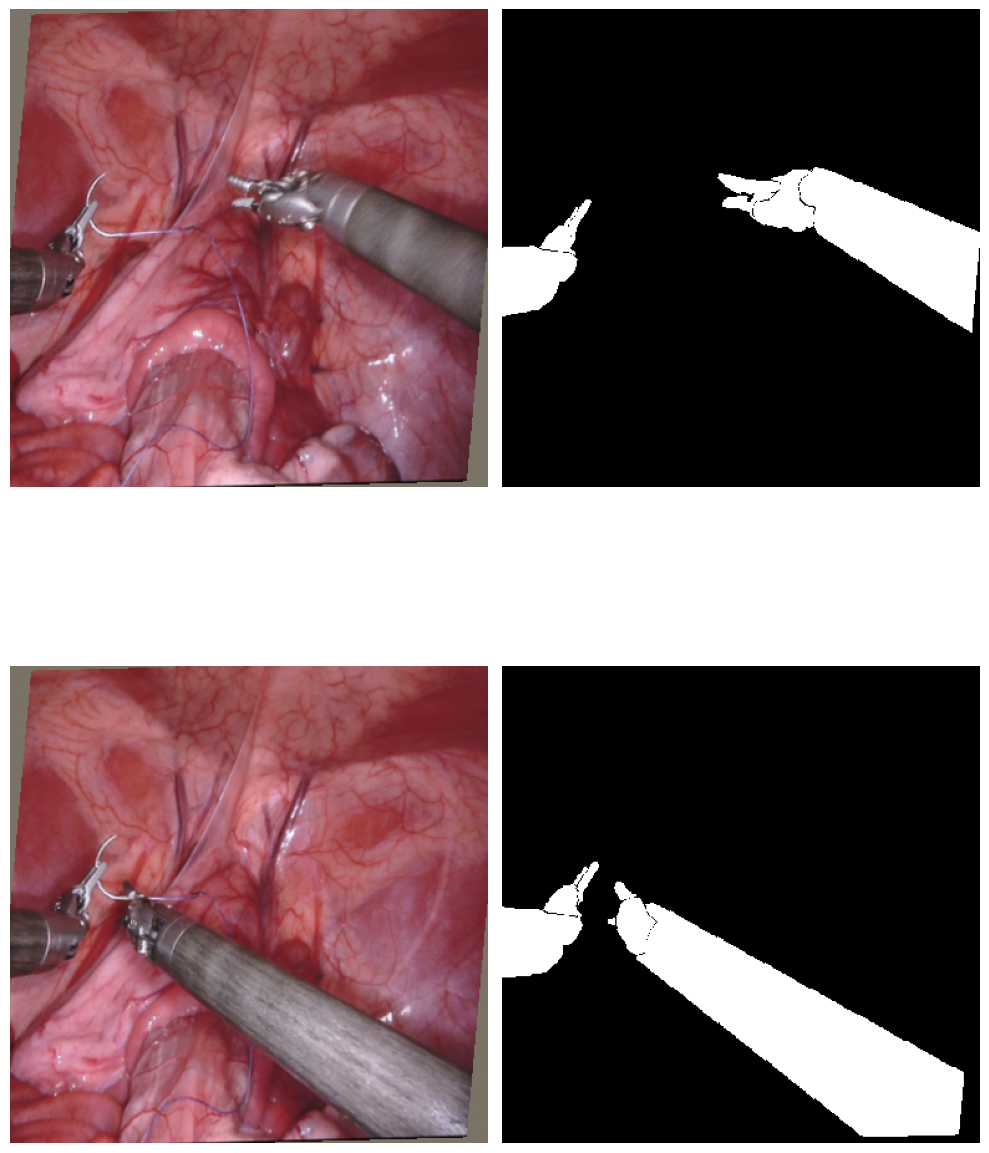

In [7]:
plotDatasetSample(train_dataset, 2)

In [6]:
from util.configuration import config